In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Reading Data

In [2]:
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

In [3]:
def combine_data(train,test):
    return pd.concat([train,test],sort=True).reset_index(drop=True)

def divide_data(data):
    return data.loc[:890],data.loc[891:].drop(['Survived'],axis=1)

all_data = combine_data(train_df,test_df)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1046 non-null   float64
 1   Cabin        295 non-null    object 
 2   Embarked     1307 non-null   object 
 3   Fare         1308 non-null   float64
 4   Name         1309 non-null   object 
 5   Parch        1309 non-null   int64  
 6   PassengerId  1309 non-null   int64  
 7   Pclass       1309 non-null   int64  
 8   Sex          1309 non-null   object 
 9   SibSp        1309 non-null   int64  
 10  Survived     891 non-null    float64
 11  Ticket       1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


# Data Exploration

### Cabin

In [4]:
# We can see that most of the values in cabin are empty, so we can drop it
train_df.drop('Cabin',axis=1,inplace=True)
test_df.drop('Cabin',axis=1,inplace=True)

### Age and Title

In [5]:
whole_df = train_df.append(test_df)
whole_df['Title'] = whole_df.Name.str.extract(r'([A-Za-z]+)\.',expand=False)
whole_df.Title.value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Major         2
Ms            2
Lady          1
Sir           1
Mme           1
Don           1
Capt          1
Countess      1
Jonkheer      1
Dona          1
Name: Title, dtype: int64

In [6]:
Common_Title = ['Mr','Mrs','Master']
whole_df['Title'].replace(['Lady','Mlle','Ms','Mme','Miss'],'Mrs',inplace=True)
whole_df['Title'].replace(['Sir', 'Rev'], 'Mr', inplace=True)
whole_df['Title'][~whole_df.Title.isin(Common_Title)] = 'Others'

In [7]:
train_df = whole_df[:len(train_df)]
test_df = whole_df[len(train_df):]
AgeMedian_by_titles = train_df.groupby('Title')['Age'].median()


In [8]:
for title in AgeMedian_by_titles.index:
    train_df['Age'][(train_df.Age.isnull()) & (train_df.Title == title)] = AgeMedian_by_titles[title]
    test_df['Age'][(test_df.Age.isnull()) & (test_df.Title == title)] = AgeMedian_by_titles[title]

In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     0 non-null      float64
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          418 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Embarked     418 non-null    object 
 11  Title        418 non-null    object 
dtypes: float64(3), int64(4), object(5)
memory usage: 42.5+ KB


### Embarked

In [10]:
train_df['Embarked'].fillna('S',inplace=True)

### Fare

In [11]:
test_df[test_df['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S,Mr


In [12]:
test_df['Fare'].fillna(7.854, inplace=True)

In [13]:
train_df['Fare'].sort_values(ascending=False).head()
train_df.loc[train_df.Fare>512, 'Fare'] = 263

# Data Transformation

In [14]:
train_df['Sex'] = train_df['Sex'].map({'female':1,'male':0}).astype('int')
test_df['Sex'] = test_df['Sex'].map({'female':1, 'male':0}).astype('int')

train_df['Embarked'] = train_df['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype('int')
test_df['Embarked'] = test_df['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype('int')

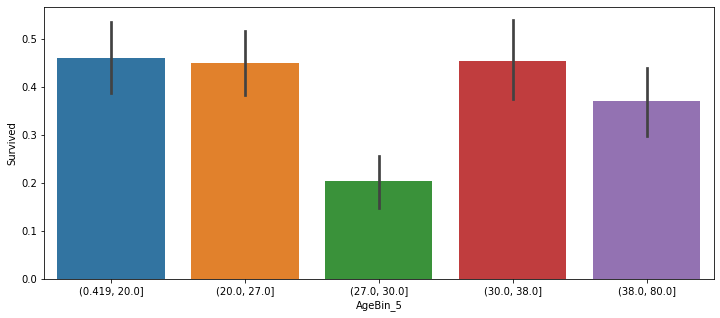

In [15]:
train_df['AgeBin_5'] = pd.qcut(train_df['Age'], 5)
test_df['AgeBin_5'] = pd.qcut(test_df['Age'], 5)

fig = plt.figure(figsize=(12,5))
sns.barplot(x='AgeBin_5', y='Survived', data=train_df)
plt.show()

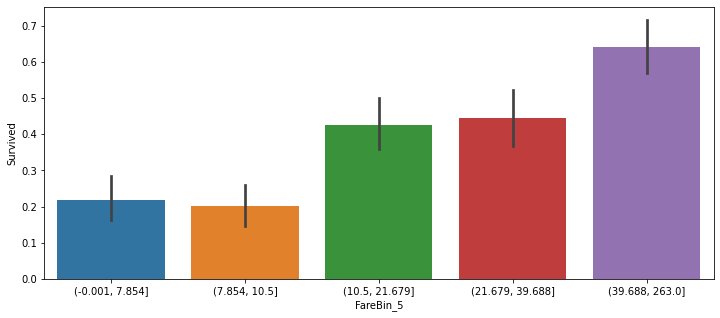

In [16]:
train_df['FareBin_5'] = pd.qcut(train_df['Fare'], 5)
test_df['FareBin_5'] = pd.qcut(test_df['Fare'], 5)

fig = plt.figure(figsize=(12,5))
sns.barplot(x='FareBin_5', y='Survived', data=train_df)
plt.show()

In [17]:
label = LabelEncoder()
train_df['AgeBin_Code_5'] = label.fit_transform(train_df['AgeBin_5'])
test_df['AgeBin_Code_5'] = label.fit_transform(test_df['AgeBin_5'])
label = LabelEncoder()
train_df['FareBin_Code_5'] = label.fit_transform(train_df['FareBin_5'])
test_df['FareBin_Code_5'] = label.fit_transform(test_df['FareBin_5'])

In [18]:
train_df['FamilySize'] = train_df.SibSp + train_df.Parch + 1
test_df['FamilySize'] = test_df.SibSp + test_df.Parch + 1

train_df['Alone'] = train_df.FamilySize.map(lambda x: 1 if x == 1 else 0)
test_df['Alone'] = test_df.FamilySize.map(lambda x: 1 if x == 1 else 0)

In [19]:
train_df['Title_Code'] = train_df.Title.map({'Mr':0, 'Mrs':1, 'Master':2, 'Others':3}).astype('int')
test_df['Title_Code'] = test_df.Title.map({'Mr':0, 'Mrs':1, 'Master':2, 'Others':3}).astype('int')

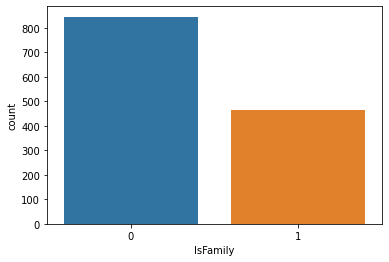

In [20]:
whole_df = train_df.append(test_df)
whole_df['Surname'] = whole_df.Name.str.extract(r'([A-Za-z]+),', expand=False)
whole_df['TixPref'] = whole_df.Ticket.str.extract(r'(.*\d)', expand=False)
whole_df['SurTix'] = whole_df['Surname'] + whole_df['TixPref']
whole_df['IsFamily'] = whole_df.SurTix.duplicated(keep=False)*1
sns.countplot(whole_df.IsFamily)
plt.show()

In [21]:
whole_df['Child'] = whole_df.Age.map(lambda x: 1 if x <= 13 else 0)
FamilyWithChild = whole_df[(whole_df.IsFamily==1)&(whole_df.Child==1)]['SurTix'].unique()
print('There are {} families with children.'.format(len(FamilyWithChild)))

There are 59 families with children.


In [22]:
whole_df['FamilyId'] = 0
x = 1
for tix in FamilyWithChild:
    whole_df.loc[whole_df.SurTix==tix, ['FamilyId']] = x
    x += 1

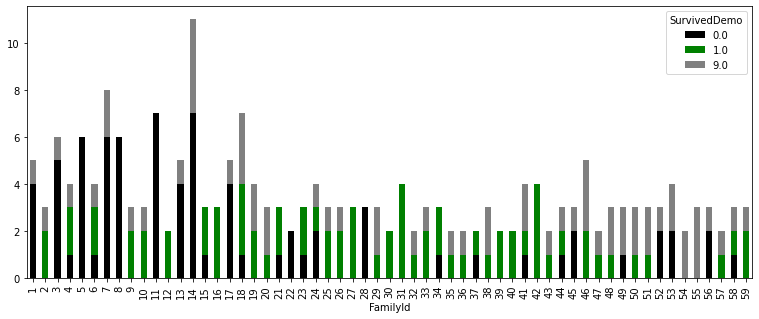

In [23]:
whole_df['SurvivedDemo'] = whole_df['Survived'].fillna(9)
pd.crosstab(whole_df.FamilyId, whole_df.SurvivedDemo).drop([0]).plot(kind='bar', stacked=True, color=['black','g','grey'], figsize=(13,5))
plt.show()

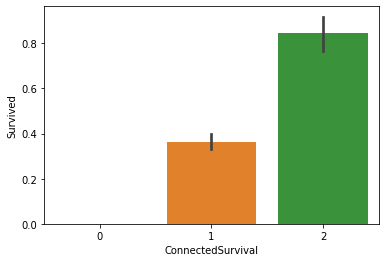

In [24]:
whole_df['ConnectedSurvival'] = 1 
Survived_by_FamilyId = whole_df.groupby('FamilyId').Survived.sum()
for i in range(1, len(FamilyWithChild)+1):
    if Survived_by_FamilyId[i] >= 1:
        whole_df.loc[whole_df.FamilyId==i, ['ConnectedSurvival']] = 2
    elif Survived_by_FamilyId[i] == 0:
        whole_df.loc[whole_df.FamilyId==i, ['ConnectedSurvival']] = 0
train_df = whole_df[:len(train_df)]
test_df = whole_df[len(train_df):]
sns.barplot(x='ConnectedSurvival', y='Survived', data=train_df)
plt.show()

In [25]:
X = train_df.drop(['Name', 'Parch', 'PassengerId', 'SibSp', 
                           'Ticket', 'Title', 'AgeBin_5', 'FareBin_5',  
                           'Surname', 'TixPref', 'SurTix', 'IsFamily', 'Child', 
                           'FamilyId', 'Survived', 'SurvivedDemo', 'Age', 'Fare'], axis=1)

y = train_df['Survived']

In [26]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [27]:
final = ['Title_Code', 'ConnectedSurvival', 'FareBin_Code_5', 'Pclass',  'FamilySize']

# MODELS

## Logistic Regression

In [28]:
model = LogisticRegression()
model.fit(X_train[final],y_train)

LogisticRegression()

In [29]:
print(f"Accuracy score for logistic regression model is {model.score(X_test[final],y_test)*100}")

Accuracy score for logistic regression model is 79.82062780269058


In [30]:
# Checking cross val score for this model
cross_val_score(model, X[final],y,cv=3)

array([0.79124579, 0.81144781, 0.82491582])

<AxesSubplot:>

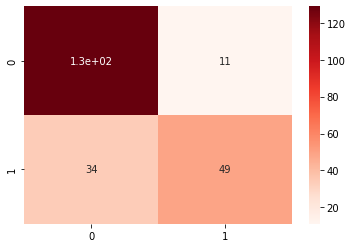

In [31]:
predict = model.predict(X_test[final])
cf = confusion_matrix(y_test,predict)
sns.heatmap(cf, cmap='Reds',annot=True)

### RandomForestClassifier

In [32]:

model = RandomForestClassifier(n_estimators=100, bootstrap=True, criterion='entropy',
                               min_samples_leaf=5, min_samples_split=4, random_state=42)

model.fit(X_train[final],y_train)

model.score(X_test[final],y_test)

0.8340807174887892

In [33]:
# Checking cross val score for this model
cross_val_score(model, X[final],y,cv=3)

array([0.83501684, 0.84511785, 0.84511785])

<AxesSubplot:>

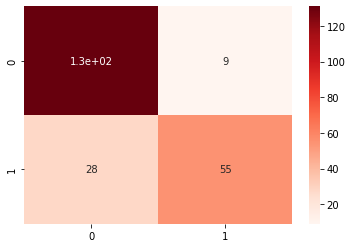

In [34]:
# Plotting the confusion matrix for this model
predict = model.predict(X_test[final])
cf = confusion_matrix(y_test,predict)
sns.heatmap(cf, cmap='Reds',annot=True)


In [35]:
# Classification report for Logistic Regression
from sklearn import metrics
print(metrics.classification_report(y_test,predict))

              precision    recall  f1-score   support

         0.0       0.82      0.94      0.88       140
         1.0       0.86      0.66      0.75        83

    accuracy                           0.83       223
   macro avg       0.84      0.80      0.81       223
weighted avg       0.84      0.83      0.83       223



## Decision Tree Classifier

In [36]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train[final],y_train)

DecisionTreeClassifier()

In [37]:
print(f"Accuracy score for Decision Tree Classifier is {model.score(X_test[final],y_test)*100}")

Accuracy score for Decision Tree Classifier is 83.40807174887892


In [38]:
# Checking cross val score for this model
cross_val_score(model, X[final],y,cv=3)

array([0.7979798 , 0.82491582, 0.83838384])

<AxesSubplot:>

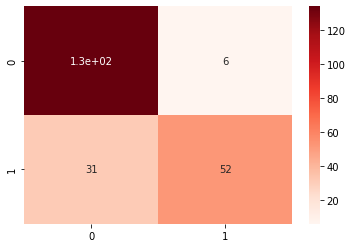

In [39]:
# Plotting the confusion matrix for this model
predict = model.predict(X_test[final])
cf = confusion_matrix(y_test,predict)
sns.heatmap(cf, cmap='Reds',annot=True)

In [40]:
# Classification report for Decision Tree Classifier
from sklearn import metrics
print(metrics.classification_report(y_test,predict))

              precision    recall  f1-score   support

         0.0       0.81      0.96      0.88       140
         1.0       0.90      0.63      0.74        83

    accuracy                           0.83       223
   macro avg       0.85      0.79      0.81       223
weighted avg       0.84      0.83      0.83       223



## UPVOTE if you liked the work